In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
import scipy.stats
from sklearn.model_selection import train_test_split

In [2]:
# φόρτωση δεδομένων
ded=pd.read_excel('CogTEL_new.xlsx')

In [3]:
# μετατροπή αλφαριθμητικών σε float και παράλληλα μετατροπή "-" σε NaN
ded['education']=pd.to_numeric(ded['education'],errors='coerce')
ded['GDS_6']=pd.to_numeric(ded['GDS_6'],errors='coerce')
ded['GDS_8']=pd.to_numeric(ded['GDS_8'],errors='coerce')
ded['GDS_9']=pd.to_numeric(ded['GDS_9'],errors='coerce')
ded['NPIJ32F']=pd.to_numeric(ded['NPIJ32F'],errors='coerce')

In [4]:
# για να μπορώ να εξάγω τις συγκεκριμένες στήλες (αχρείαστο βήμα...)
ded = ded.rename(columns={'Antidepressants ': 'Antidepressants' })
ded = ded.rename(columns={'Concentration/attention' : 'Concentration_attention'})

In [5]:
# αφαίρεση στιγμιοτύπων με missing values
ded=ded.dropna()

In [6]:
# αφαίρεση των παραδειγμάτων ηλικίας 50 και κάτω
dedomena=ded[ded['Age']>49]

In [7]:
dedomena.shape

(504, 61)

In [8]:
# ανάθεση του συνόλου των ανεξάρτητων μεταβλητών και της μεταβλητής στόχου σε Χ και Υ
X=dedomena.drop('diagnosis',axis=1)
Y=dedomena.diagnosis

In [9]:
!pip install imblearn
!pip install imbalanced-learn

Class=0, n=208 (25.000%)
Class=2, n=208 (25.000%)
Class=1, n=208 (25.000%)
Class=3, n=208 (25.000%)


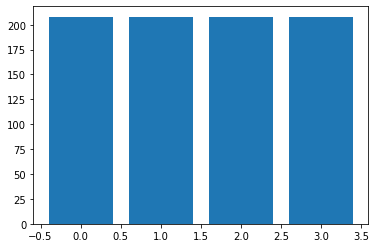

In [10]:
# τεχνική υπερδειγματοληψίας SMOTE 

from collections import Counter
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=7)
X, Y = oversample.fit_resample(X, Y)
# summarize distribution
counter = Counter(Y)
for k,v in counter.items():
    per = v / len(Y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [11]:
# διαχωρισμός δεδομένων σε train και test set (μέθοδος hold-out)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=3)

In [12]:
# προεπιλεγμένες υπερπαράμετροι
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

abc = AdaBoostClassifier(random_state=4)

model = abc.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.584


In [13]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82        69
           1       0.54      0.36      0.43        69
           2       0.68      0.38      0.49        66
           3       0.40      0.83      0.54        46

    accuracy                           0.58       250
   macro avg       0.61      0.60      0.57       250
weighted avg       0.62      0.58      0.57       250



In [14]:
abc.score(X_train,Y_train)

0.6460481099656358

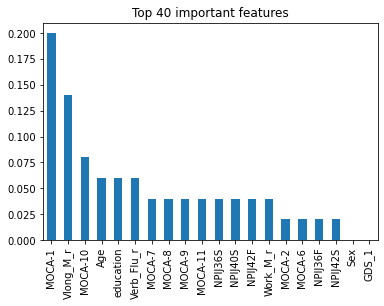

In [27]:
# feature importance 
feat_importances = pd.Series(abc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='bar')
plt.title("Top 40 important features")
plt.show()

In [15]:
# Κάνουμε nested CV 
# αργεί
from sklearn.model_selection import GridSearchCV,cross_val_score,RepeatedKFold,KFold

clf1=AdaBoostClassifier(random_state=6,algorithm='SAMME')
inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
space=dict()
space['learning_rate']=[0.1, 0.2, 0.5]
space['n_estimators']=[100, 200, 300, 400, 500]
search = GridSearchCV(clf1, space, scoring='f1_micro', n_jobs=-1, cv=inner_cv, refit=True)
search.fit(X, Y)

nested_scores=cross_val_score(search, X, Y, scoring='f1_micro',cv=outer_cv, n_jobs=-1)
nested_scores

array([0.7005988 , 0.70658683, 0.6746988 , 0.63253012, 0.69879518])

In [16]:
nested_scores.mean()

0.6826419450256115

In [17]:
search.best_params_

{'learning_rate': 0.2, 'n_estimators': 400}

In [18]:
bestestimator=search.best_estimator_
bestestimator

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.2, n_estimators=400,
                   random_state=6)

# ΟVO και OVR (ή OVA)

In [20]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

In [21]:
dec= OneVsOneClassifier(AdaBoostClassifier(random_state=1))
dec.fit(X_train, Y_train)

y_pred = dec.predict(X_test)

print('Precision-micro of OvO Classifier: {:.2f}'.format(precision_score(Y_test, y_pred, average='micro')))
print('Recall-micro of OvO Classifier: {:.2f}'.format(recall_score(Y_test, y_pred, average='micro')))
print('f1-micro of OvO Classifier: {:.2f}'.format(f1_score(Y_test, y_pred, average='micro')))

Precision-micro of OvO Classifier: 0.78
Recall-micro of OvO Classifier: 0.78
f1-micro of OvO Classifier: 0.78


In [24]:
# nested cv για ΟVO
# αργεί πολύ (15')
# για τον συντονισμό των υπερπαραμέτρων με τους ταξινομητές OVO και OVR χρησιμοποιείται το πρόθεμα 'estimator__' για κάθε υπερπαράμετρο που ελέγχουμε
clf=OneVsOneClassifier(AdaBoostClassifier(random_state=6))
inner_cv = KFold(n_splits=5, shuffle= True, random_state=1)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
space['estimator__n_estimators']=[100, 200, 400]
search = GridSearchCV(clf, space, scoring='f1_micro', n_jobs=-1, cv=inner_cv, refit=True)
search.fit(X, Y)

nested_scores=cross_val_score(search, X, Y, scoring='f1_micro', cv=outer_cv, n_jobs=-1,error_score="raise")
nested_scores


array([0.83333333, 0.86904762, 0.77108434, 0.75903614, 0.74698795,
       0.78313253, 0.86746988, 0.84337349, 0.8313253 , 0.85542169])

In [25]:
nested_scores.mean()

0.8160212277682156

In [26]:
dec= OneVsRestClassifier(AdaBoostClassifier(random_state=6))
dec.fit(X_train, Y_train)

y_pred = dec.predict(X_test)

print('Precision-micro of OvR Classifier: {:.2f}'.format(precision_score(Y_test, y_pred, average='micro')))
print('Recall-micro of OvR Classifier: {:.2f}'.format(recall_score(Y_test, y_pred, average='micro')))
print('f1-micro of OvR Classifier: {:.2f}'.format(f1_score(Y_test, y_pred, average='micro')))

Precision-micro of OvR Classifier: 0.78
Recall-micro of OvR Classifier: 0.78
f1-micro of OvR Classifier: 0.78


In [28]:
# nested cv για ΟVR
# αργεί πολύ (15')
# για τον συντονισμό των υπερπαραμέτρων με τους ταξινομητές OVO και OVR χρησιμοποιείται το πρόθεμα 'estimator__' για κάθε υπερπαράμετρο που ελέγχουμε
clf=OneVsRestClassifier(AdaBoostClassifier(random_state=6))
inner_cv = KFold(n_splits=5, shuffle= True, random_state=1)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
space['estimator__n_estimators']=[100, 200, 400]
search = GridSearchCV(clf, space, scoring='f1_micro', n_jobs=-1, cv=inner_cv, refit=True)
search.fit(X, Y)

nested_scores=cross_val_score(search, X, Y, scoring='f1_micro', cv=outer_cv, n_jobs=-1,error_score="raise")
nested_scores

array([0.80952381, 0.80952381, 0.80722892, 0.75903614, 0.75903614,
       0.79518072, 0.79518072, 0.74698795, 0.86746988, 0.81927711])

In [29]:
nested_scores.mean()

0.7968445209409066